### Chapter 18
**CH18 Forecasting daily ticket sales for a swimming pool**

using swim data

version 1.1 2024-01-10

In [1]:
import pandas as pd
import numpy as np
import warnings
import sys
import os

# import pandas_market_calendars as 
import holidays
from datetime import datetime
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from mizani.formatters import date_format
from patsy import dmatrices
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

warnings.filterwarnings("ignore")

In [2]:
# !pip install holidays

In [3]:
%matplotlib inline

### Get Data

In [4]:
# Current script and repository folder
current_path = os.getcwd()
repository_path = current_path.split('Ch18')[0]

In [5]:
# Add utils folder to sys path 
# Note: os.path.join() creates a string with the right syntax for defining a path for your operating sytem.
sys.path.append(os.path.join(repository_path, 'utils'))

In [6]:
# Define data folder
data_path = os.path.join(repository_path, 'data')

In [7]:
# Import the prewritten helper functions
from py_helper_functions import *

In [8]:
# DATA IMPORT - FROM GITHUB
data = pd.read_csv('https://raw.githubusercontent.com/peterduronelly/DA3-Python-Codes/main/data/swim_work.csv')

In [9]:
data.head()

,date,QUANTITY
0,2010-01-01,0
1,2010-01-02,49
2,2010-01-03,31
3,2010-01-04,14
4,2010-01-05,18


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      2557 non-null   object
 1   QUANTITY  2557 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 40.1+ KB


### EDA

In [11]:
daily_agg = data.copy()

In [12]:
daily_agg.date = pd.to_datetime(daily_agg.date, format= '%Y-%m-%d')

In [13]:
daily_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2557 non-null   datetime64[ns]
 1   QUANTITY  2557 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 40.1 KB


In [14]:
daily_agg["year"] = daily_agg["date"].dt.year
daily_agg["quarter"] = daily_agg["date"].dt.quarter
daily_agg["month"] = daily_agg["date"].dt.month
daily_agg["day"] = daily_agg["date"].dt.day
daily_agg["dow"] = daily_agg["date"].dt.dayofweek + 1
daily_agg["weekend"] = daily_agg["dow"].isin([6, 7])

In [15]:
daily_agg["school_off"] = (
    ((daily_agg["day"] > 15) & (daily_agg["month"] == 5) & (daily_agg["day"] <= 30))
    | ((daily_agg["month"] == 6) | (daily_agg["month"] == 7))
    | ((daily_agg["day"] < 15) & (daily_agg["month"] == 8))
    | ((daily_agg["day"] > 20) & (daily_agg["month"] == 12))
)

In [16]:
daily_agg["trend"] = daily_agg.index + 1

In [17]:
# Get holiday calendar ----------------------------------

In [18]:
minyear = daily_agg.date.min().year
maxyear = daily_agg.date.max().year

In [19]:
usholidays = holidays.UnitedStates(years = [x for x in range(minyear, maxyear + 1, 1)])

In [20]:
for dat in usholidays.items():
    print(dat)

(datetime.date(2016, 1, 1), "New Year's Day")
(datetime.date(2016, 5, 30), 'Memorial Day')
(datetime.date(2016, 7, 4), 'Independence Day')
(datetime.date(2016, 9, 5), 'Labor Day')
(datetime.date(2016, 11, 11), 'Veterans Day')
(datetime.date(2016, 11, 24), 'Thanksgiving')
(datetime.date(2016, 12, 25), 'Christmas Day')
(datetime.date(2016, 12, 26), 'Christmas Day (observed)')
(datetime.date(2016, 1, 18), 'Martin Luther King Jr. Day')
(datetime.date(2016, 2, 15), "Washington's Birthday")
(datetime.date(2016, 10, 10), 'Columbus Day')
(datetime.date(2010, 1, 1), "New Year's Day")
(datetime.date(2010, 12, 31), "New Year's Day (observed)")
(datetime.date(2010, 5, 31), 'Memorial Day')
(datetime.date(2010, 7, 4), 'Independence Day')
(datetime.date(2010, 7, 5), 'Independence Day (observed)')
(datetime.date(2010, 9, 6), 'Labor Day')
(datetime.date(2010, 11, 11), 'Veterans Day')
(datetime.date(2010, 11, 25), 'Thanksgiving')
(datetime.date(2010, 12, 25), 'Christmas Day')
(datetime.date(2010, 12, 24

In [21]:
holiday_days = [x[0] for x in usholidays.items()]

In [22]:
holiday_days[0:10]

[datetime.date(2016, 1, 1),
 datetime.date(2016, 5, 30),
 datetime.date(2016, 7, 4),
 datetime.date(2016, 9, 5),
 datetime.date(2016, 11, 11),
 datetime.date(2016, 11, 24),
 datetime.date(2016, 12, 25),
 datetime.date(2016, 12, 26),
 datetime.date(2016, 1, 18),
 datetime.date(2016, 2, 15)]

In [23]:
daily_agg.date[0]

Timestamp('2010-01-01 00:00:00')

In [24]:
daily_agg["isHoliday"] = daily_agg["date"].isin(holiday_days)

Did we get the holidays right?

In [25]:
daily_agg[daily_agg.date == datetime(2010,7,4)]

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday
184,2010-07-04,10,2010,3,7,4,7,True,True,185,True


Is *Maria Himmelfahrt* a holiday in the US?

In [26]:
daily_agg[daily_agg.date == datetime(2010,8,15)]

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday
226,2010-08-15,22,2010,3,8,15,7,True,False,227,False


### Define vars for analysis

In [27]:
daily_agg["q_month"] = daily_agg.groupby("month")["QUANTITY"].transform("mean")

daily_agg["QUANTITY2"] = np.where(daily_agg["QUANTITY"] < 1, 1, daily_agg["QUANTITY"])

daily_agg["q_ln"] = np.log(daily_agg["QUANTITY2"])

daily_agg["tickets"] = daily_agg.groupby(["month", "dow"])["QUANTITY"].transform("mean")

daily_agg["tickets_ln"] = daily_agg.groupby(["month", "dow"])["q_ln"].transform("mean")

daily_agg["dow_abb"] = daily_agg["date"].dt.day_name().str[:3]

daily_agg["month_abb"] = daily_agg["date"].dt.month_name().str[:3]

## Descriptive graphs

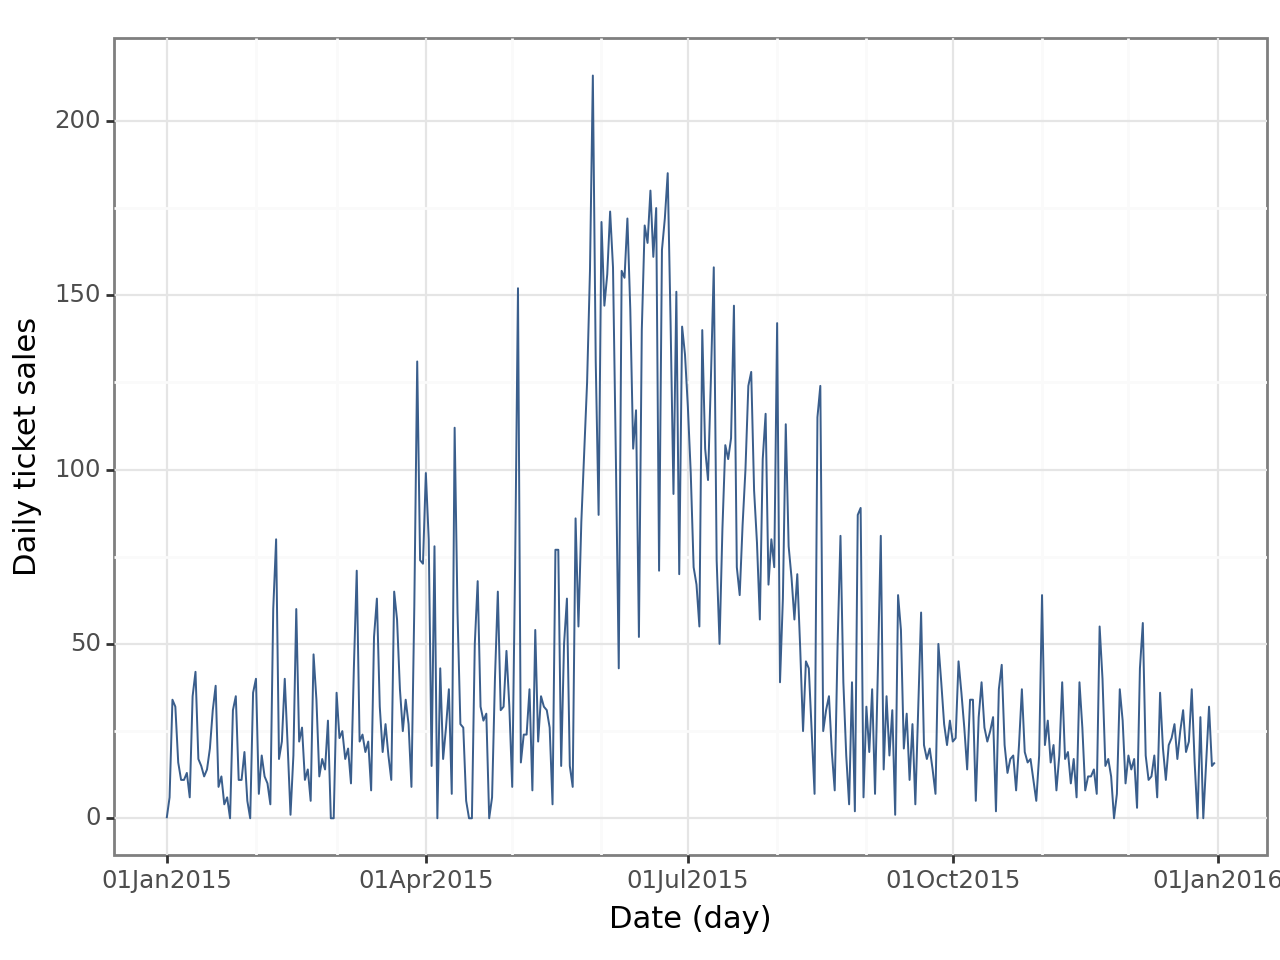

<Figure Size: (640 x 480)>

In [28]:
ggplot(
    daily_agg.loc[daily_agg.year == 2015, :], aes(x="date", y="QUANTITY")
) + geom_line(size=0.4, color=color[0]) + scale_x_date(
    breaks=["2015-01-01", "2015-04-01", "2015-07-01", "2015-10-01", "2016-01-01"],
    labels=date_format("%d%b%Y"),
    date_minor_breaks="1 month",
) + labs(
    x="Date (day)", y="Daily ticket sales"
) + theme_bw()

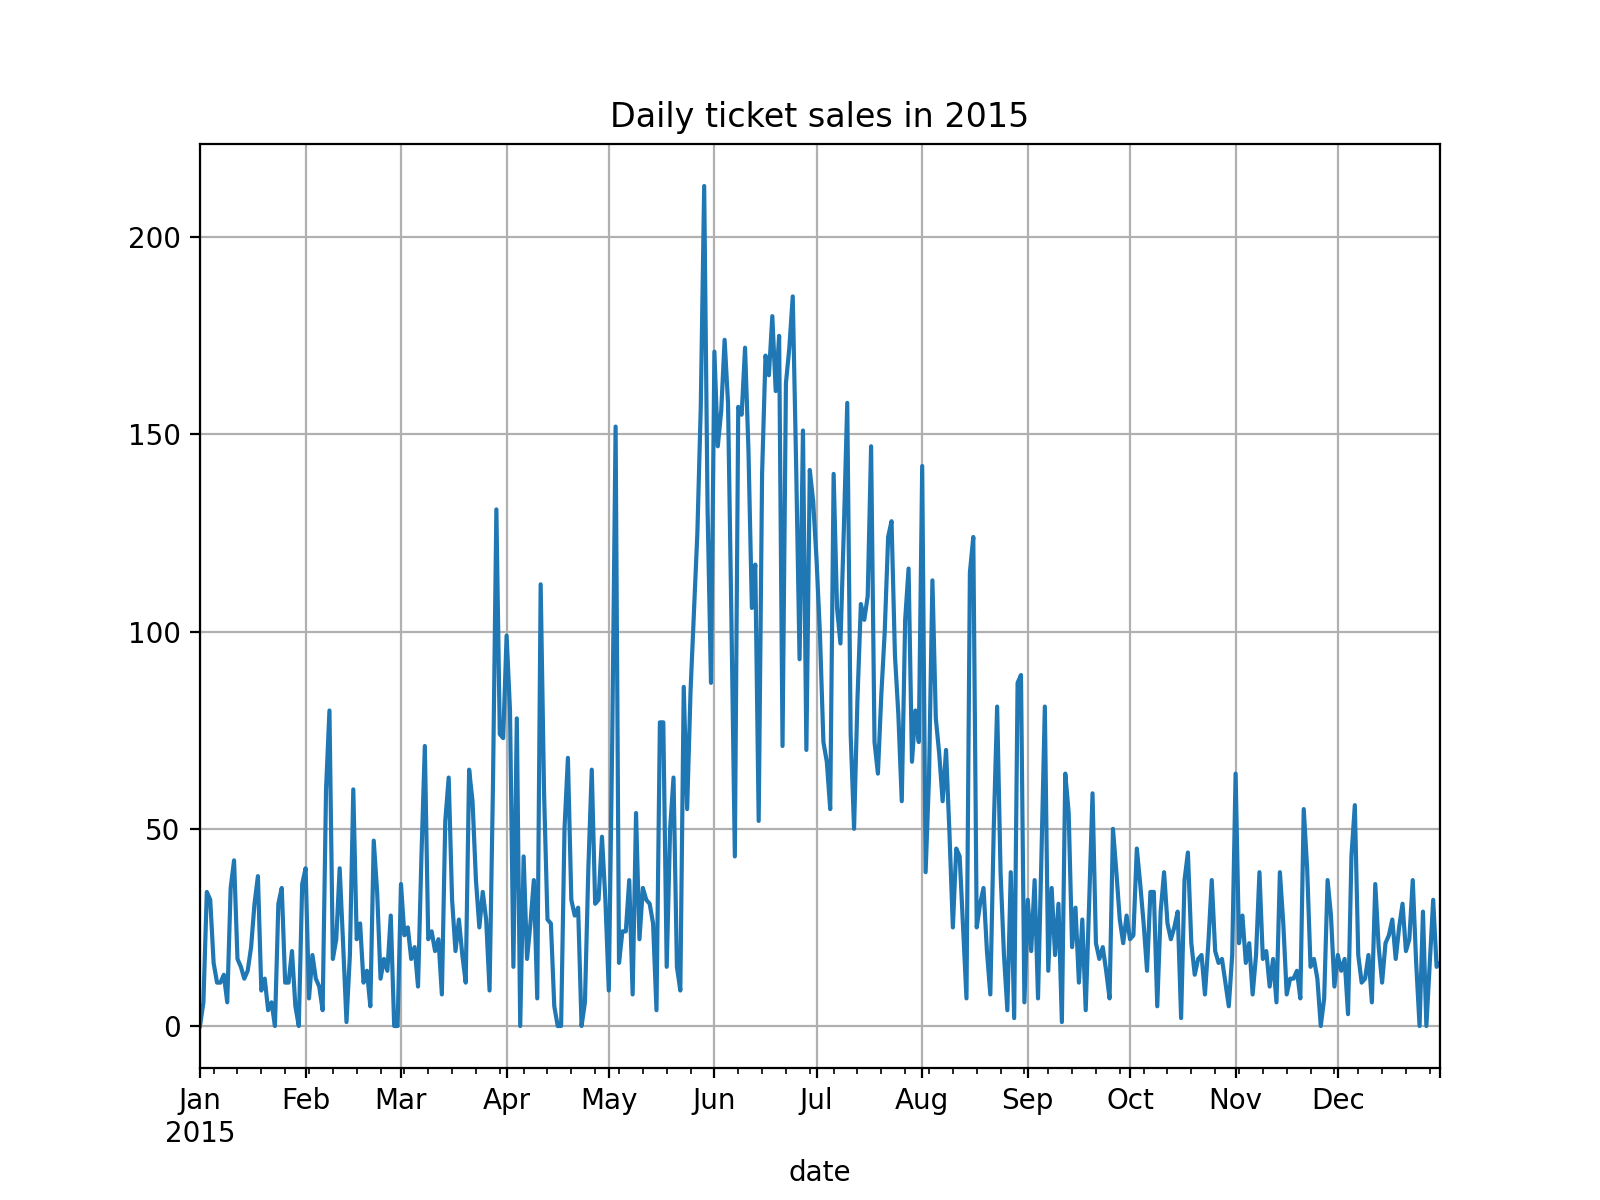

In [29]:
daily_agg[daily_agg.year == 2015].plot(
    kind = 'line', figsize = (8,6),
    x = 'date', y = 'QUANTITY', 
    grid = True, legend = False, title = 'Daily ticket sales in 2015');

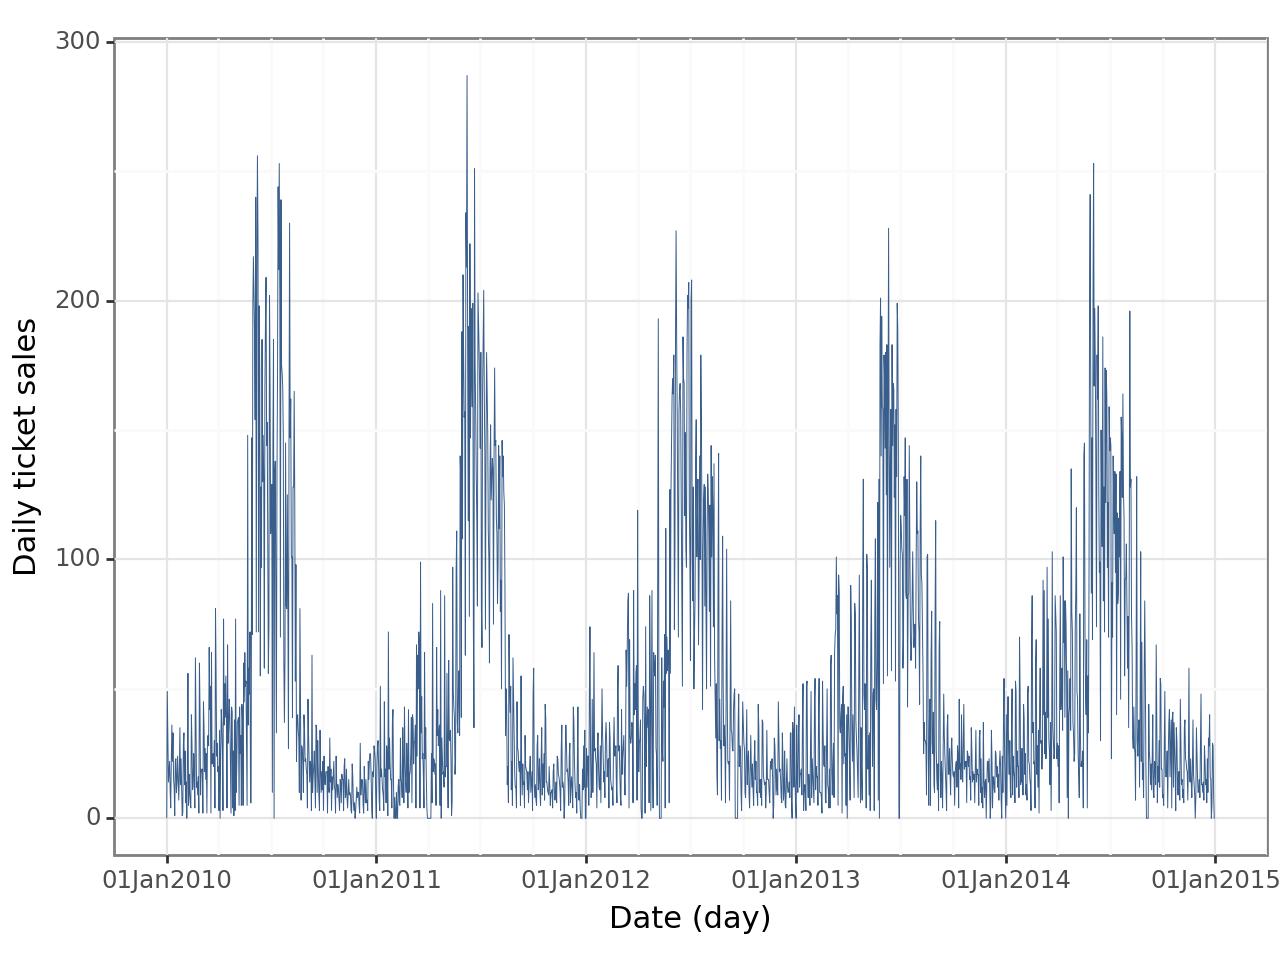

<Figure Size: (640 x 480)>

In [30]:
ggplot(
    daily_agg.loc[(daily_agg.year >= 2010) & (daily_agg.year <= 2014), :],
    aes(x="date", y="QUANTITY"),
) + geom_line(size=0.2, color=color[0]) + scale_x_date(
    breaks=[
        "2010-01-01",
        "2011-01-01",
        "2012-01-01",
        "2013-01-01",
        "2014-01-01",
        "2015-01-01",
    ],
    labels=date_format("%d%b%Y"),
    date_minor_breaks="3 months",
) + labs(
    x="Date (day)", y="Daily ticket sales"
) + theme_bw()

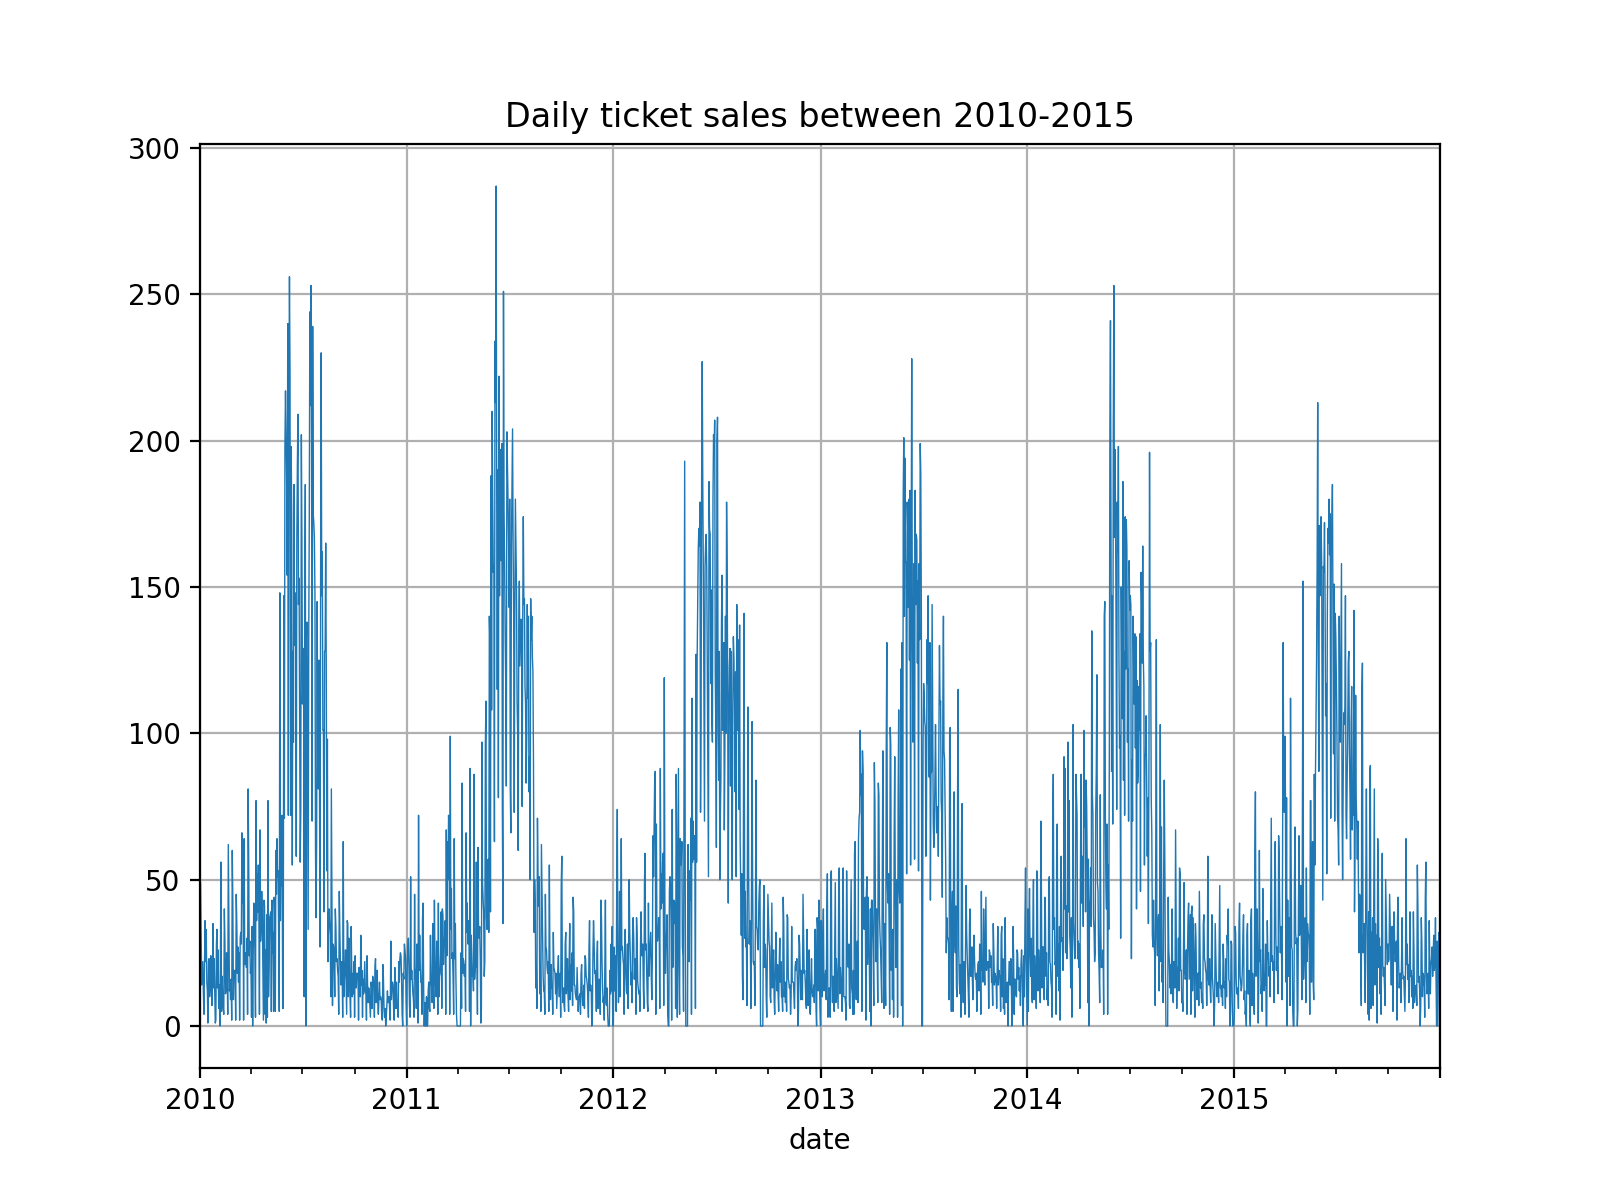

In [31]:
daily_agg[daily_agg.year < 2016].plot(
    kind = 'line', figsize = (8,6),
    x = 'date', y = 'QUANTITY', linewidth = 0.5,
    grid = True, legend = False, title = 'Daily ticket sales between 2010-2015');

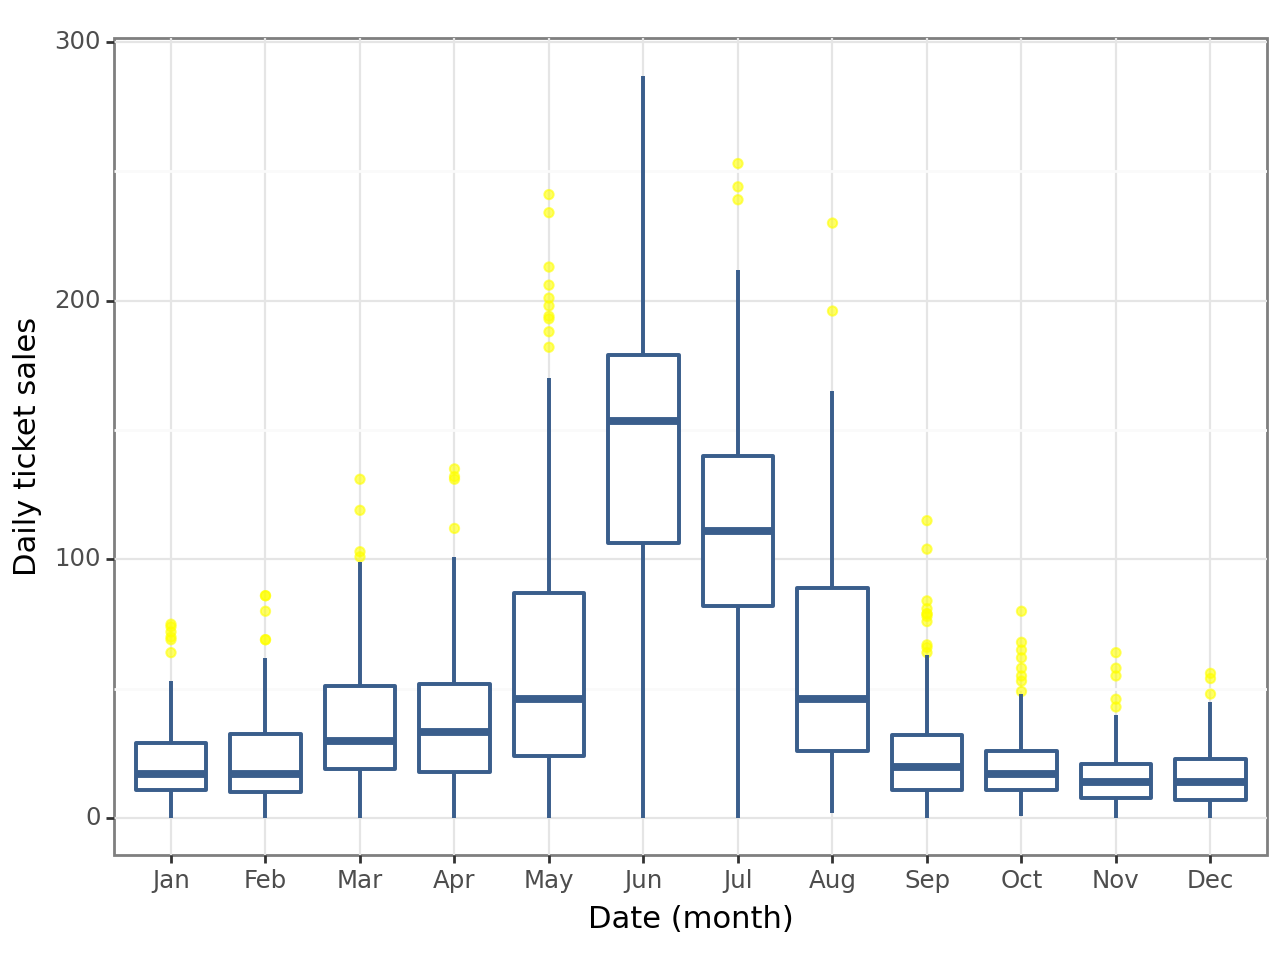

<Figure Size: (640 x 480)>

In [32]:
ggplot(daily_agg, aes(x="reorder(month_abb,month)", y="QUANTITY")) + geom_boxplot(
    color=color[0],size=0.8, outlier_stroke=0.4, outlier_color="yellow", outlier_alpha=0.6
) + labs(x="Date (month)", y="Daily ticket sales") + theme_bw()

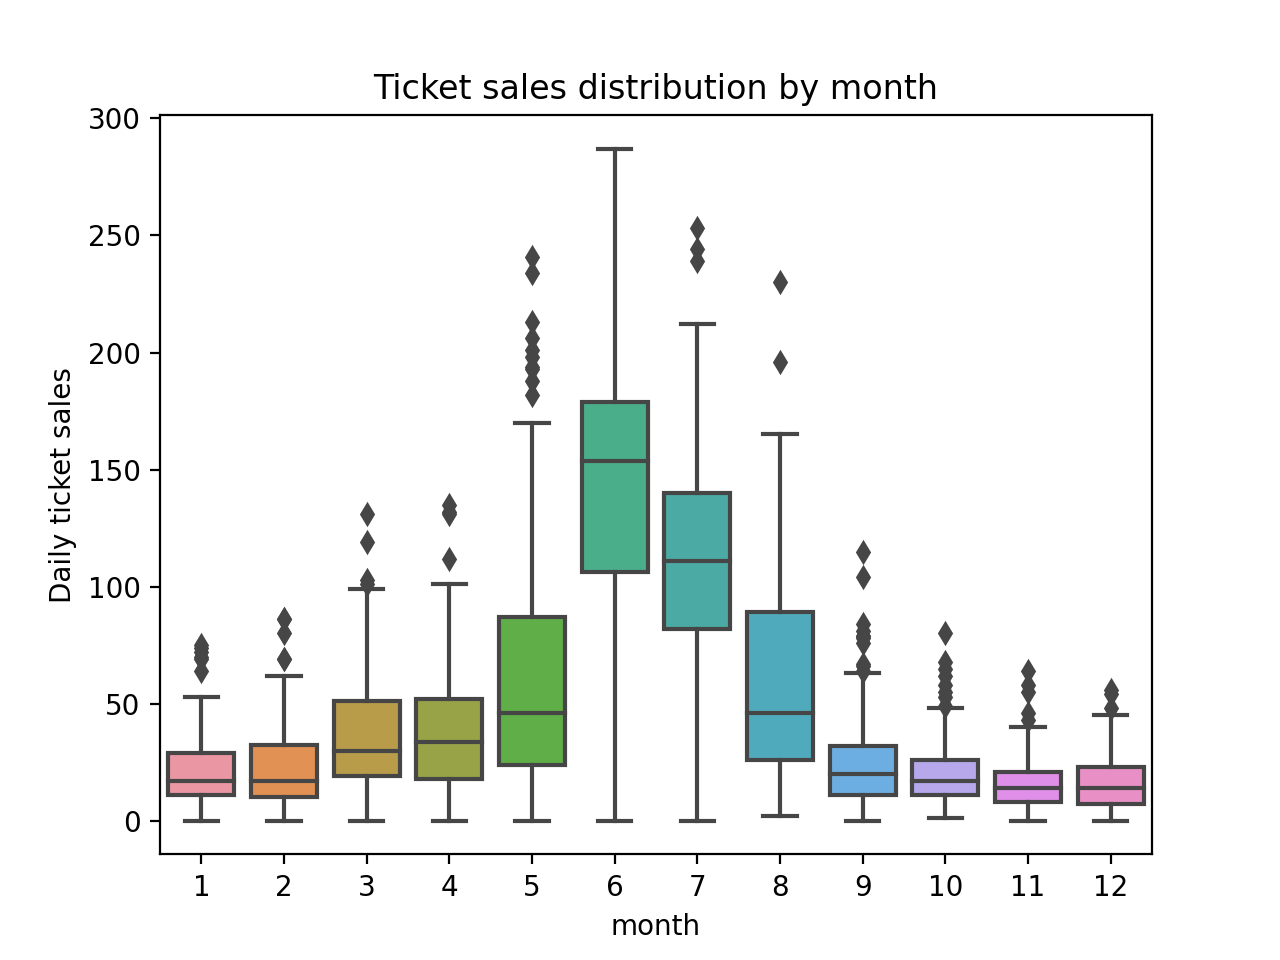

In [33]:
ax = sns.boxplot(data= daily_agg, x = 'month', y = 'QUANTITY')
ax.set_ylabel('Daily ticket sales')
ax.set_title('Ticket sales distribution by month');

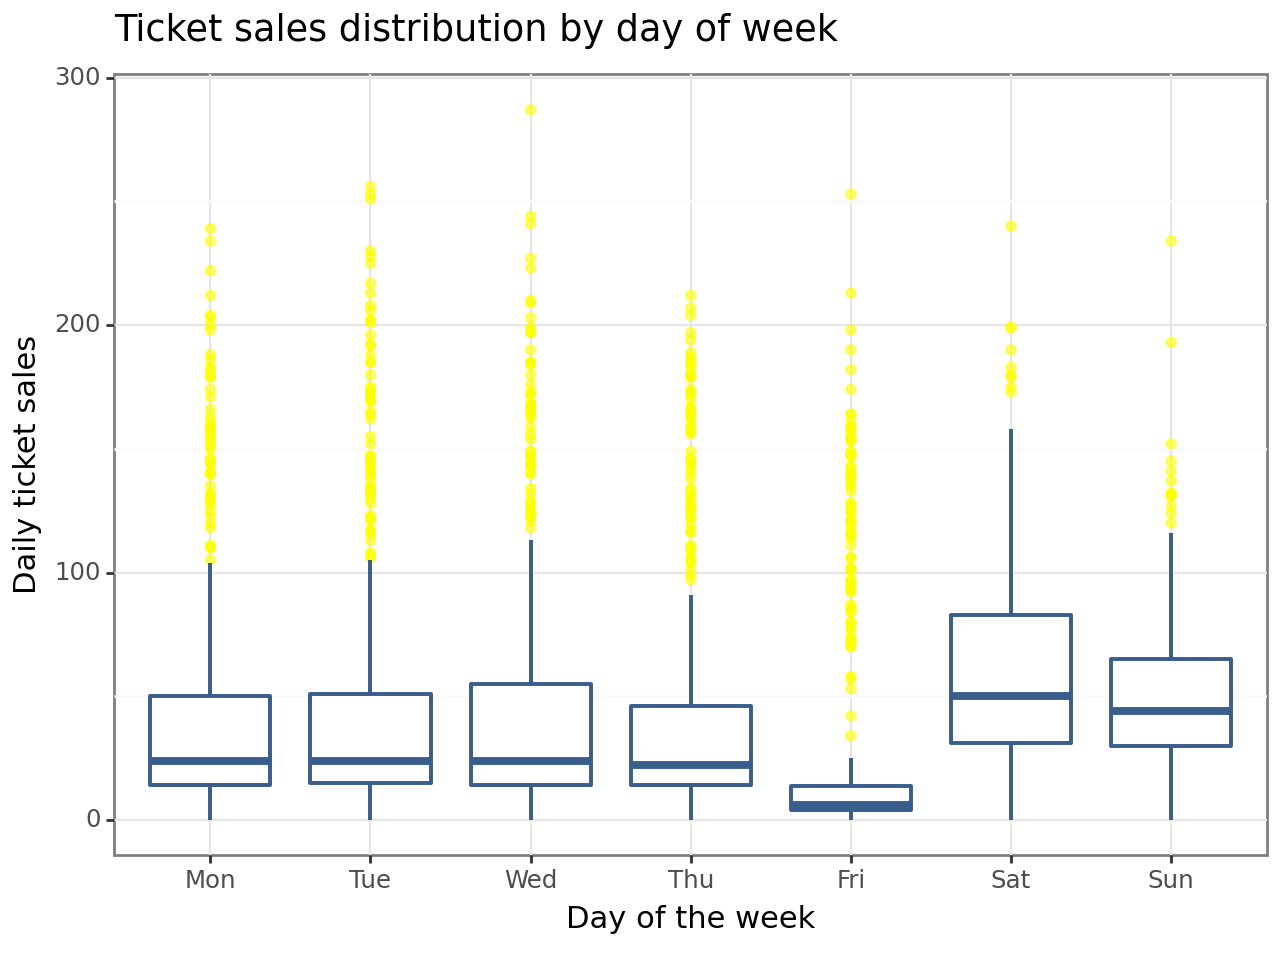

<Figure Size: (640 x 480)>

In [34]:
ggplot(
    daily_agg, aes(x="reorder(dow_abb,dow)", y="QUANTITY")
) + geom_boxplot(
    color=color[0],size=0.8, outlier_stroke=0.4, outlier_color="yellow", outlier_alpha=0.6
) + labs(x="Day of the week", y="Daily ticket sales", title = 'Ticket sales distribution by day of week'
) + theme_bw()

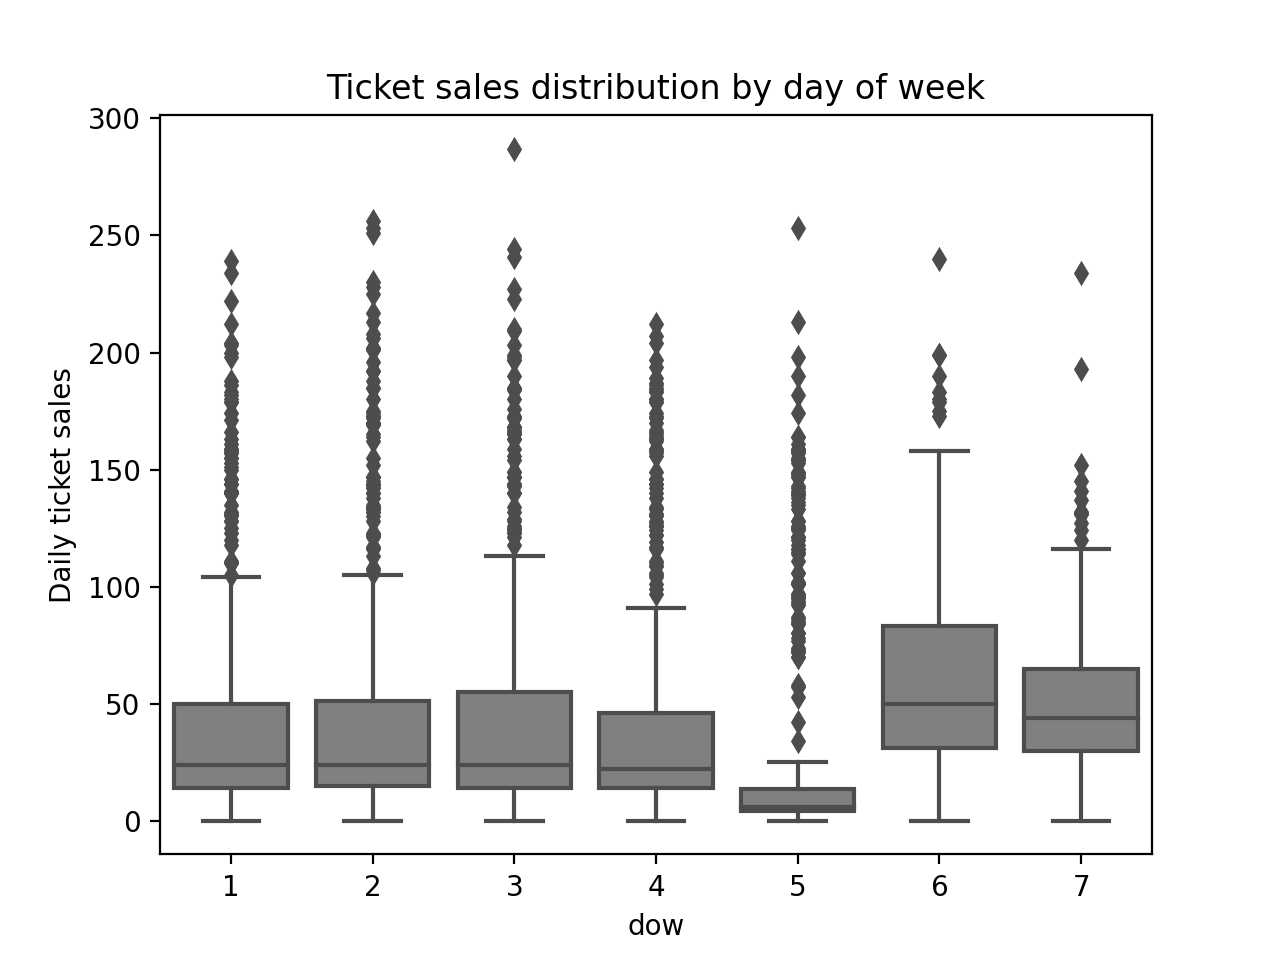

In [35]:
ax = sns.boxplot(data= daily_agg, x = 'dow', y = 'QUANTITY', color = 'grey')
ax.set_ylabel('Daily ticket sales')
ax.set_title('Ticket sales distribution by day of week');

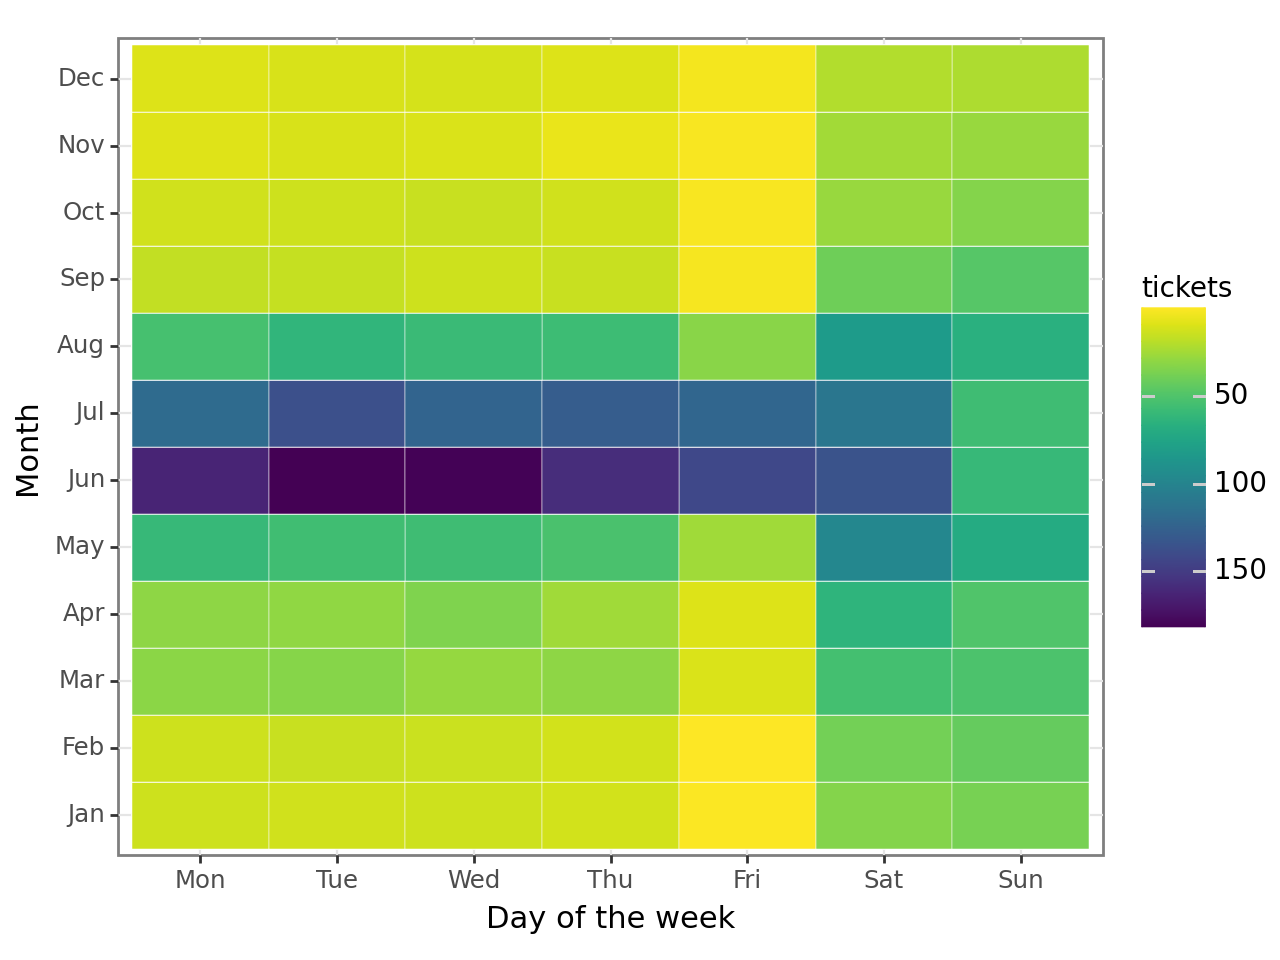

<Figure Size: (640 x 480)>

In [36]:
# to check for interactions, look at the heatmap

swim_heatmap = (
    ggplot(
        daily_agg,
        aes(x="reorder(dow_abb,dow)", y="reorder(month_abb,month)", fill="tickets"),
    )
    + geom_tile(colour="white")
    + scale_fill_cmap(trans="reverse")
    + labs(x="Day of the week", y="Month") 
    + theme_bw()
    + theme(
        legend_position="right",
        legend_text=element_text(size=10),
        legend_title=element_text(size=10),
    )
)
swim_heatmap

In [37]:
daily_agg.pivot_table(index="month", columns="dow", values="QUANTITY", aggfunc='sum')

dow,1,2,3,4,5,6,7
month,,,,,,,
1,507,504,520,499,165,1162,1259
2,500,517,519,451,113,1148,1251
3,1054,1127,980,1036,423,1722,1644
4,1004,985,1127,858,406,1938,1501
5,1901,1782,1729,1675,898,3008,2290
6,4794,5320,5475,4651,4045,3987,1841
7,3517,4194,3795,3933,3866,3386,1800
8,1755,1979,1853,1763,1081,2568,2081
9,599,584,526,571,194,1225,1482


In [38]:
daily_agg.pivot_table(index="month", columns="dow", values="QUANTITY", aggfunc='mean')

dow,1,2,3,4,5,6,7
month,,,,,,,
1,16.900000,16.800000,17.333333,16.096774,5.156250,36.312500,39.343750
2,17.241379,18.464286,17.896552,16.107143,4.035714,41.000000,44.678571
3,34.000000,35.218750,31.612903,33.419355,14.100000,55.548387,53.032258
4,33.466667,32.833333,37.566667,28.600000,13.096774,64.600000,51.758621
5,61.322581,57.483871,57.633333,54.032258,28.967742,97.032258,71.562500
6,159.800000,177.333333,176.612903,155.033333,139.482759,132.900000,61.366667
7,117.233333,135.290323,122.419355,126.870968,120.812500,109.225806,58.064516
8,54.843750,63.838710,59.774194,58.766667,34.870968,82.838710,67.129032
9,19.966667,19.466667,17.533333,18.419355,6.466667,42.241379,49.400000


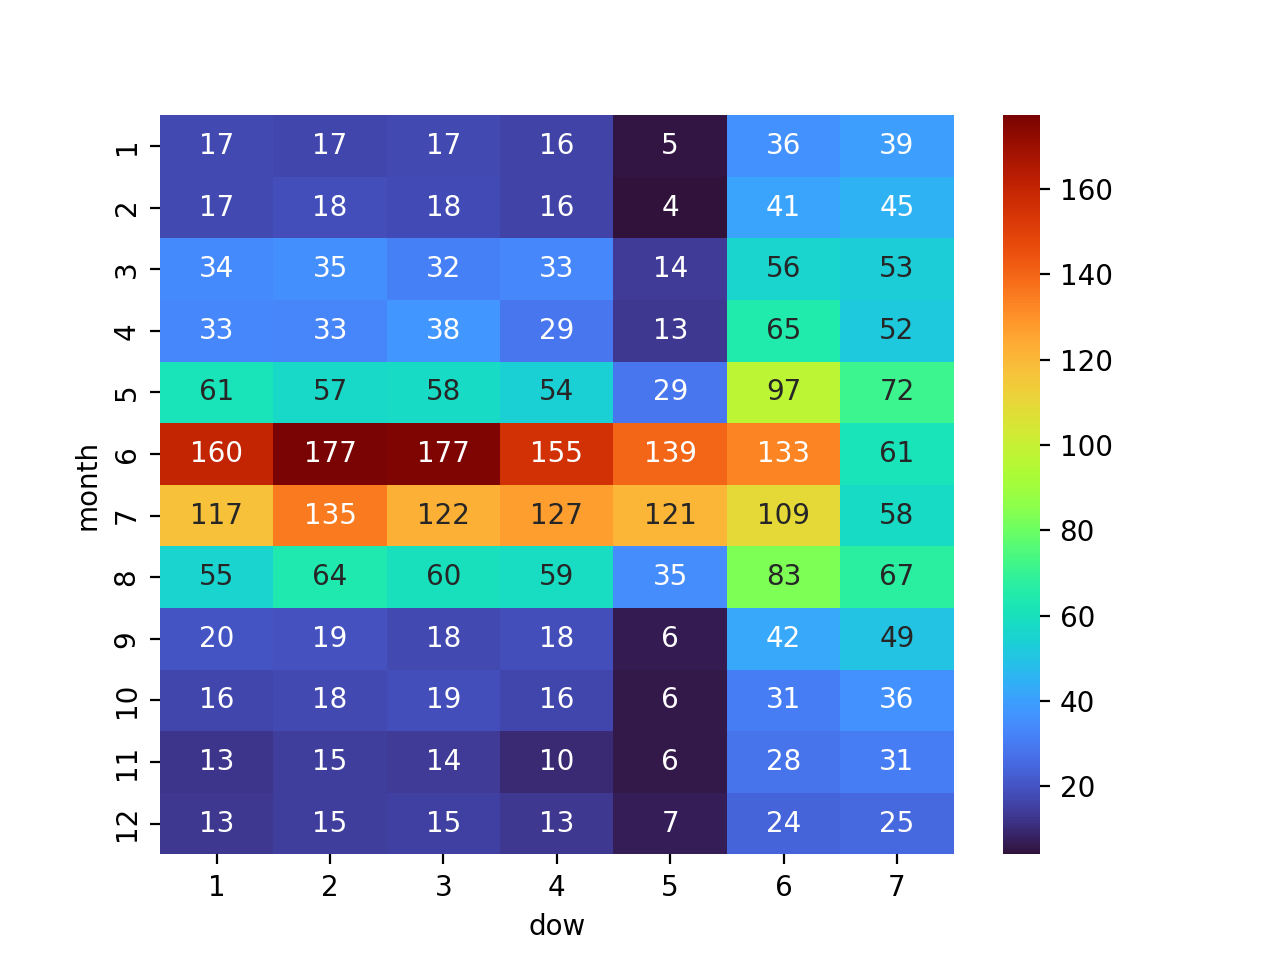

In [39]:
sns.heatmap(
    data = daily_agg.pivot_table(index="month", columns="dow", values="QUANTITY", aggfunc='mean'), 
    annot = True, 
    # which colormap do you prefer?
    cmap = 'turbo',
    # cmap = 'coolwarm',
    fmt = '.0f');

`matplotlib` colormaps [here](https://matplotlib.org/stable/users/explain/colors/colormaps.html)

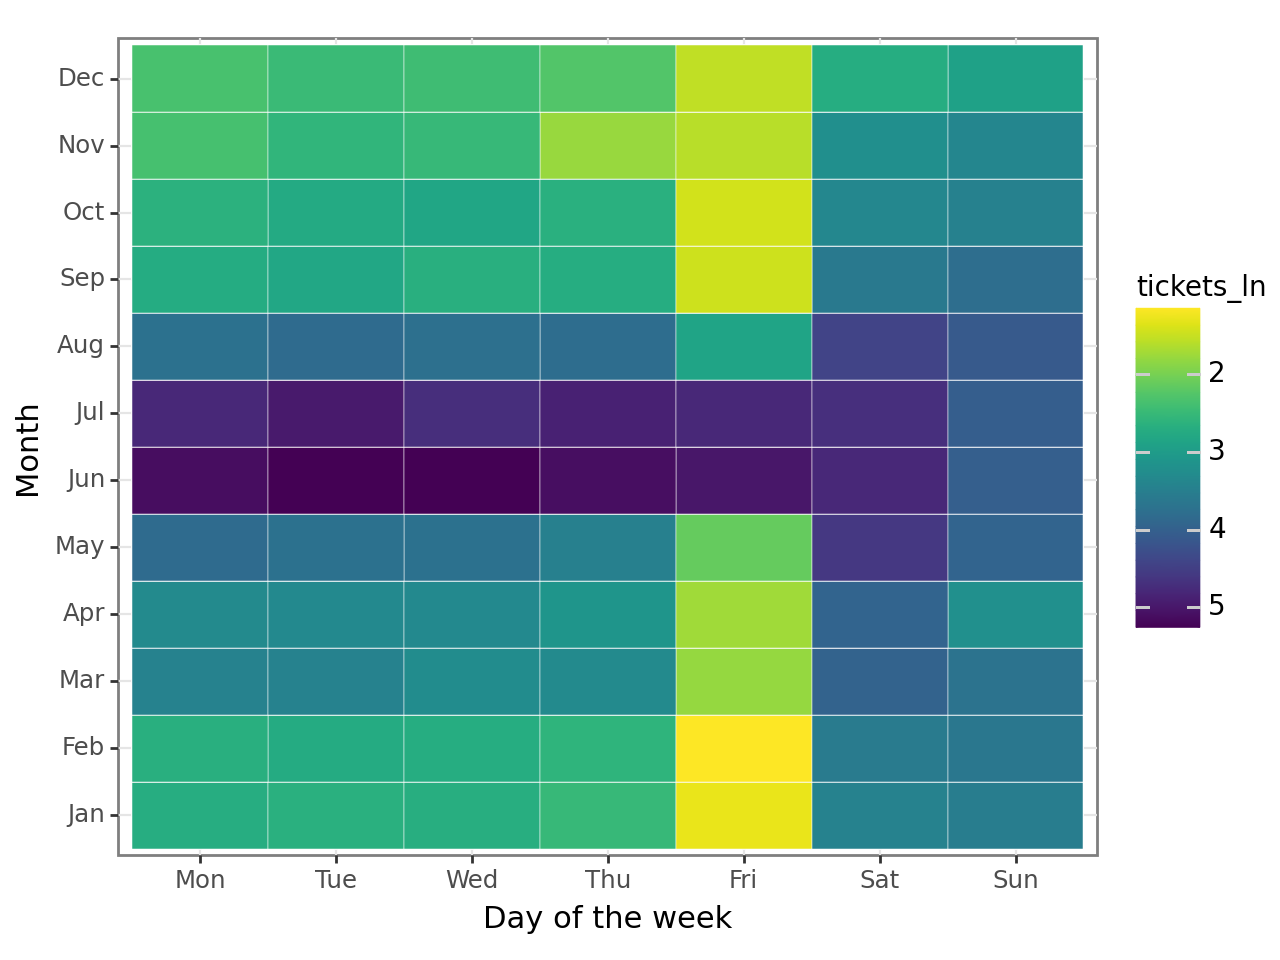

<Figure Size: (640 x 480)>

In [40]:
swim_heatmap_log = (
    ggplot(
        daily_agg,
        aes(x="reorder(dow_abb,dow)", y="reorder(month_abb,month)", fill="tickets_ln"),
    )
    + geom_tile(colour="white")
    + scale_fill_cmap(trans="reverse")
    + labs(x="Day of the week", y="Month") 
    + theme_bw()
    + theme(
        legend_position="right",
        legend_text=element_text(size=10),
        legend_title=element_text(size=10),
    )
)
swim_heatmap_log

### Prediction

#### Create train/holdout data

In [41]:
factor_cols = ["month", "dow", "isHoliday", "school_off"]

daily_agg[factor_cols] = daily_agg[factor_cols].astype("category")
data_holdout = daily_agg.loc[daily_agg['year']==2016,:]
data_train = daily_agg.loc[daily_agg['year']<2016,:]

In [42]:
data_train.tail()

,date,QUANTITY,year,quarter,month,day,dow,weekend,school_off,trend,isHoliday,q_month,QUANTITY2,q_ln,tickets,tickets_ln,dow_abb,month_abb
2186,2015-12-27,0,2015,4,12,27,7,True,True,2187,False,15.97235,1,0.000000,25.266667,2.927724,Sun,Dec
2187,2015-12-28,16,2015,4,12,28,1,False,True,2188,False,15.97235,16,2.772589,13.483871,2.392609,Mon,Dec
2188,2015-12-29,32,2015,4,12,29,2,False,True,2189,False,15.97235,32,3.465736,14.612903,2.507322,Tue,Dec
2189,2015-12-30,15,2015,4,12,30,3,False,True,2190,False,15.97235,15,2.708050,14.903226,2.470384,Wed,Dec
2190,2015-12-31,16,2015,4,12,31,4,False,True,2191,False,15.97235,16,2.772589,13.093750,2.321463,Thu,Dec


In [43]:
logo = LeaveOneGroupOut()
groups = data_train.loc[:,'year'].to_numpy()
groups

array([2010, 2010, 2010, ..., 2015, 2015, 2015])

Note: `LeaveOneOut()` is equivalent to `KFold(n_splits=n)`

In [44]:
data_train.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015])

#### Linear regression

In [45]:
lin_reg = LinearRegression(fit_intercept=False)

LeaveOneGroupOut object's `split` method:
- **X**: array-like of shape (n_samples, n_features); training data, where n_samples is the number of samples and n_features is the number of features.
- **y**: object; always ignored, exists for compatibility.
- **groups**: object; always ignored, exists for compatibility.

In [46]:
def fit_cv_model_get_rmse(y, X, groups):
    rmse_folds = []
    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lin_reg.fit(X_train, y_train)
        y_hat = lin_reg.predict(X_test)
        rmse_folds.append(mean_squared_error(y_test, y_hat, squared=False))

    return np.mean(rmse_folds)

**Model 1: linear trend + monthly seasonality**

In [47]:
%%time
y, X = dmatrices("QUANTITY ~ 1+ trend + month", data_train)

rmse_reg1 = fit_cv_model_get_rmse(y, X, groups)

CPU times: total: 31.2 ms
Wall time: 48.4 ms


**Model 2: linear trend + monthly seasonality + days of week seasonality**

In [48]:
y,X = dmatrices("QUANTITY ~ 1+ trend + month + dow",data_train)

rmse_reg2 = fit_cv_model_get_rmse(y, X, groups)

**Model 3: linear trend + monthly seasonality + days of week  seasonality + holidays**

In [49]:
y,X = dmatrices("QUANTITY ~ 1 + trend + month + dow + isHoliday",data_train)

rmse_reg3 = fit_cv_model_get_rmse(y, X, groups)

**Model 4: linear trend + monthly seasonality + days of week  seasonality + holidays + sch$*$dow**

In [50]:
y,X = dmatrices("QUANTITY ~ 1 + trend + month + dow + isHoliday + school_off*dow",data_train)

rmse_reg4 = fit_cv_model_get_rmse(y, X, groups)

**Model 5: linear trend + monthly seasonality + days of week  seasonality + holidays + interactions**

In [51]:
y, X = dmatrices(
    "QUANTITY ~ 1 + trend + month + dow + isHoliday + school_off*dow+ weekend*month",
    data_train,
)

rmse_reg5 = fit_cv_model_get_rmse(y, X, groups)

In [52]:
data_train2 = data_train[data_train.QUANTITY >= 1]
groups = data_train2.loc[:,'year'].to_numpy()

Note: we could have done:
```python
groups = data_train2.year.to_numpy()
```

**Model 6: trend + monthly seasonality + days of week seasonality + holidays + interactions**

Why is it different than Model 5?

In [53]:
y, X = dmatrices(
    "q_ln ~ 1 + trend + month + dow +school_off*dow", data_train2
)

rmse_folds = []
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lin_reg.fit(X_train, y_train)
    y_hat = lin_reg.predict(X)

    corrb = mean_squared_error(y , y_hat)

    y_hat = np.exp((lin_reg.predict(X_test) + corrb / 2))
    rmse_folds.append(mean_squared_error(np.exp(y_test), y_hat, squared=False))

rmse_reg6 = np.mean(rmse_folds)
# rmse_reg6

#### Prophet

Cross-validation with `Prophet` done with prophet: https://facebook.github.io/prophet/docs/diagnostics.html. This is a *time-series-based (!!!)* cross-validation.

In [55]:
# !pip install prophet

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/24/2b/834e9a347f2f0161e32a3c6125b8a1ebdf6ac33199a0ed3a0bdf1f0c296f/prophet-1.1.5-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/5b/a0/a0f4a556dff2189bc08d0f69f0d4aac1b7e4e0cedc9a70b30a134f73d100/cmdstanpy-1.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources from https://files.pythonhosted.org/packages/93/e8/facde510585869b5ec694e8e0363ffe4eba067cb357a8398a55f6a1f8023/importlib_resources-6.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for stanio~=0.3.0 from https://files.pythonhosted.org/packages/26/01/e2579afa3ad1eade8b54bf5b9e45790d219681b1f8f97edbd2f18c4e1a7d/stanio-0.3.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   - -----

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [56]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

*Question*: why are we building an additive model?

In [57]:
model_prophet = Prophet(
    seasonality_mode="additive",
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    growth="linear",
    daily_seasonality=True,
)

model_prophet = Prophet.add_country_holidays(model_prophet,"US")

In [58]:
model_prophet = Prophet.fit(
    model_prophet,
    df=data_train[["date", "QUANTITY"]].rename({"date": "ds", "QUANTITY": "y"}, axis=1),
)

17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
cv_pred = cross_validation(
    model_prophet, 
    initial="365 days", 
    period="365 days", 
    horizon="365 days"
)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/5 [00:00<?, ?it/s]

17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:34 - cmdstanpy - INFO - Chain [1] done processing
17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
cv_pred

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-01-02,4.550890,-33.749862,40.636584,20,2011-01-01
1,2011-01-03,16.057294,-16.350487,53.176573,27,2011-01-01
2,2011-01-04,29.085913,-7.647792,66.768608,30,2011-01-01
3,2011-01-05,23.005668,-13.861609,60.240892,20,2011-01-01
4,2011-01-06,13.909459,-22.398077,50.499146,7,2011-01-01
...,...,...,...,...,...,...
1820,2015-12-27,18.327307,-16.570448,54.968411,0,2014-12-31
1821,2015-12-28,20.612038,-17.901953,58.324412,16,2014-12-31
1822,2015-12-29,26.712900,-9.610538,62.120080,32,2014-12-31
1823,2015-12-30,25.835056,-11.980006,63.214128,15,2014-12-31


In [61]:
performance_metrics(cv_pred,rolling_window = 1)

,horizon,mse,rmse,mae,mdape,smape,coverage
0,365 days,867.720677,29.457099,20.285698,0.448286,0.61766,0.820274


In [62]:
rmse_prophet_cv = performance_metrics(cv_pred, rolling_window = 1)["rmse"][0]

Note: M6 log model rmse is slightly different from the one found in the book

In [63]:
pd.DataFrame(
    [rmse_reg1, rmse_reg2, rmse_reg3, rmse_reg4, rmse_reg5, rmse_reg6, rmse_prophet_cv],
    ["M" + str(i) for i in range(1, 6)] + ["M6 (log)", "M7 (Prophet)"],
    columns=["RMSE"],
).round(2)

,RMSE
M1,32.35
M2,31.45
M3,31.45
M4,27.59
M5,26.89
M6 (log),30.04
M7 (Prophet),29.46


### Evaluate best model on the holdout set

In [64]:
lin_reg = LinearRegression(fit_intercept=False)

y, X = dmatrices(
    "QUANTITY ~ 1 + trend + month + dow + isHoliday + school_off*dow+ weekend*month",
    data_train,
)

lin_reg.fit(X, y)

_, X_holdout = dmatrices(
    "QUANTITY ~ 1 + trend + month + dow + isHoliday + school_off*dow+ weekend*month",
    data_holdout,
)

*Question*: what is '`_`' in the previous code chunk?

In [65]:
data_holdout["y_hat_5"] = lin_reg.predict(X_holdout)

In [66]:
rmse_holdout_best = mean_squared_error(
    data_holdout.QUANTITY, 
    data_holdout.y_hat_5, 
    squared=False # default: True > returns MSE
)
rmse_holdout_best

24.57859425657195

#### Detour: interpreting regression coefficients

In [67]:
y, X = dmatrices(
    "QUANTITY ~ trend + month + dow + isHoliday + school_off*dow+ weekend*month",
    data_train,
)

In [68]:
best_ols_results = sm.OLS(y, X).fit()

In [69]:
print(best_ols_results.summary2())

                       Results: Ordinary least squares
Model:                   OLS                 Adj. R-squared:        0.733     
Dependent Variable:      QUANTITY            AIC:                   20578.6813
Date:                    2024-02-12 17:54    BIC:                   20794.9816
No. Observations:        2191                Log-Likelihood:        -10251.   
Df Model:                37                  F-statistic:           163.7     
Df Residuals:            2153                Prob (F-statistic):    0.00      
R-squared:               0.738               Scale:                 690.42    
------------------------------------------------------------------------------
                             Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
------------------------------------------------------------------------------
Intercept                    18.2444   2.9580  6.1677 0.0000  12.4435  24.0453
month[T.2]                   -0.6370   3.3091 -0.1925 0.8474  -7.1264   5.85

<br>

- What does it mean?

```
"The smallest eigenvalue is 6.54e-28. This might indicate that there are 
strong multicollinearity problems or that the design matrix is singular" 

```
.

In [70]:
best_ols_results.eigenvals

array([3.50835416e+09, 9.76408927e+02, 7.19940570e+02, 5.09148916e+02,
       3.43082090e+02, 3.42460155e+02, 3.41919556e+02, 3.41908963e+02,
       2.05503835e+02, 2.04977881e+02, 2.04350302e+02, 2.02620577e+02,
       2.01897895e+02, 2.00475806e+02, 1.98097516e+02, 1.96352879e+02,
       1.86215676e+02, 8.92234035e+01, 7.17395953e+01, 5.75688953e+01,
       5.72677533e+01, 5.70988045e+01, 5.69409225e+01, 5.01649187e+01,
       4.57816195e+01, 3.46958247e+01, 3.45955148e+01, 3.44292656e+01,
       3.42584955e+01, 3.38793318e+01, 3.37885294e+01, 3.33543503e+01,
       3.29147215e+01, 3.15837875e+01, 1.37733434e+01, 1.11227388e+01,
       5.67301549e+00, 2.36146868e+00, 3.60807092e-27])

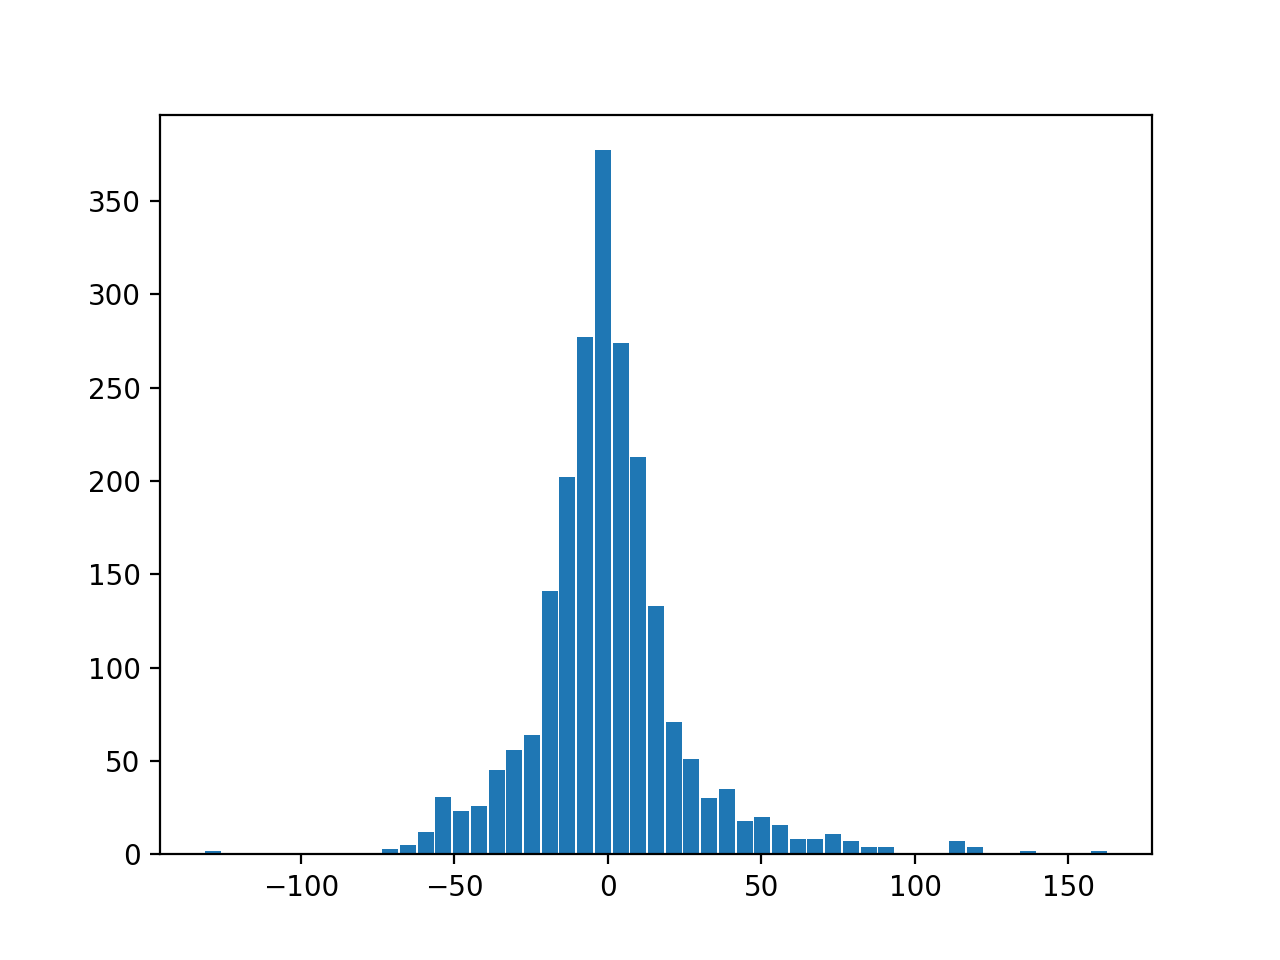

In [71]:
plt.hist(best_ols_results.resid, bins = 51, rwidth = 0.9);

### Plot best predictions

Relative RMSE on the holdout set per month

In [72]:
group = data_holdout.sort_values(by=["month"]).groupby("month")

In [73]:
type(group)

pandas.core.groupby.generic.DataFrameGroupBy

In [74]:
group.apply(lambda x: mean_squared_error(x.QUANTITY, x.y_hat_5, squared=False))

month
1     10.984683
2     11.991934
3     18.924835
4     19.227395
5     46.242648
6     33.396922
7     31.441215
8     32.034850
9     12.919108
10    17.036840
11     7.954719
12    20.388873
dtype: float64

In [75]:
rmse_monthly = pd.DataFrame(
    [
        group.apply(lambda x: mean_squared_error(x.QUANTITY, x.y_hat_5, squared=False)),
        group.apply(
            lambda x: mean_squared_error(x.QUANTITY, x.y_hat_5, squared=False) / np.mean(x.QUANTITY)
        ),
    ],
    index=["RMSE", "RMSE_norm"],
).T.reset_index()

In [76]:
rmse_monthly

,month,RMSE,RMSE_norm
0,1,10.984683,0.487858
1,2,11.991934,0.434165
2,3,18.924835,0.583751
3,4,19.227395,0.483505
4,5,46.242648,0.746626
5,6,33.396922,0.254614
6,7,31.441215,0.257511
7,8,32.034850,0.590416
8,9,12.919108,0.486901
9,10,17.036840,0.702317


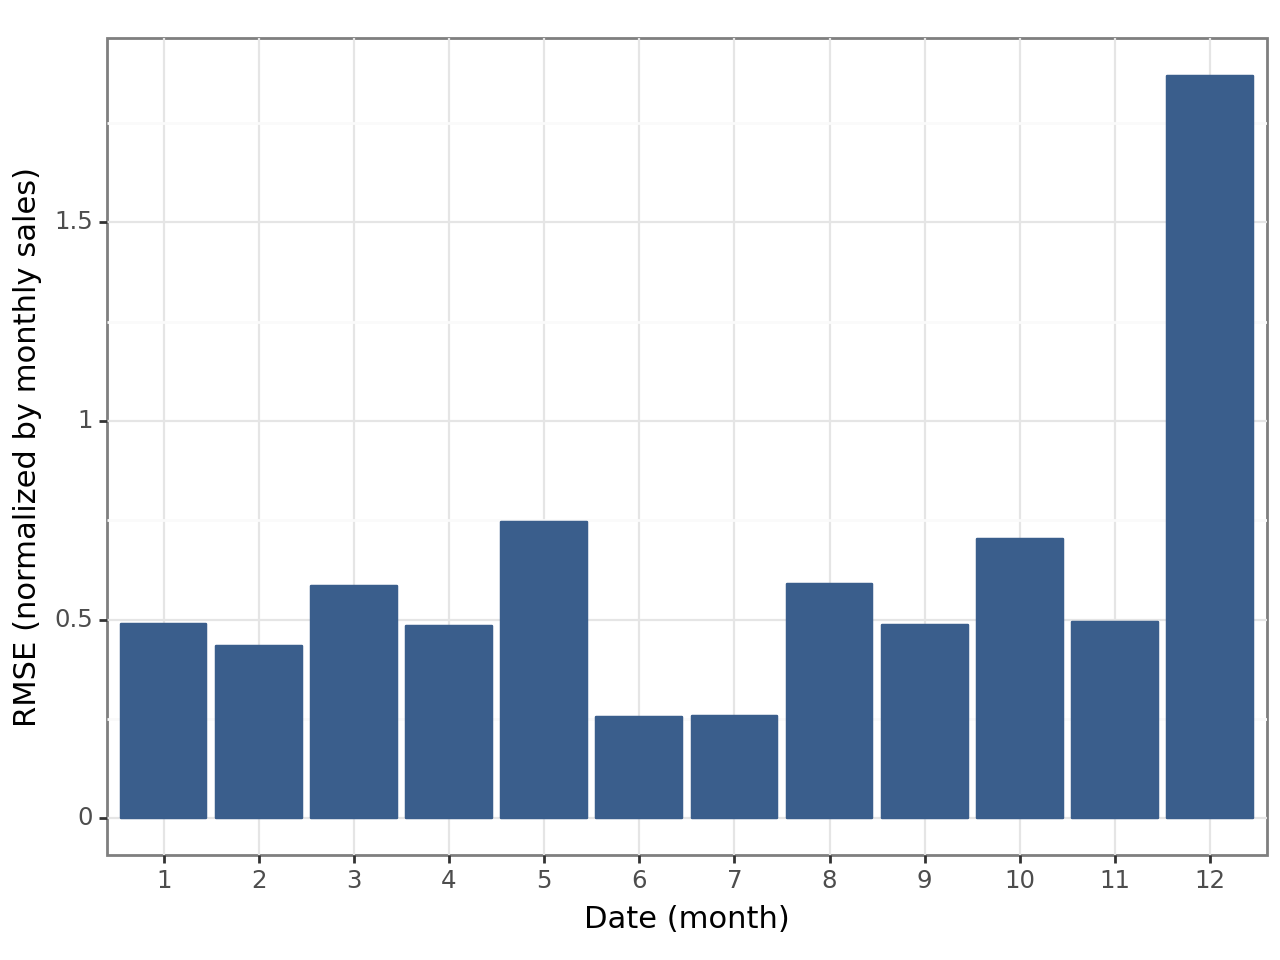

<Figure Size: (640 x 480)>

In [77]:
g_predictions_rmse = (
    ggplot(rmse_monthly, aes(x="month", y="RMSE_norm"))
    + geom_col(color=color[0],fill=color[0])
    + labs(x="Date (month)", y="RMSE (normalized by monthly sales)")
    + theme_bw()
)
g_predictions_rmse

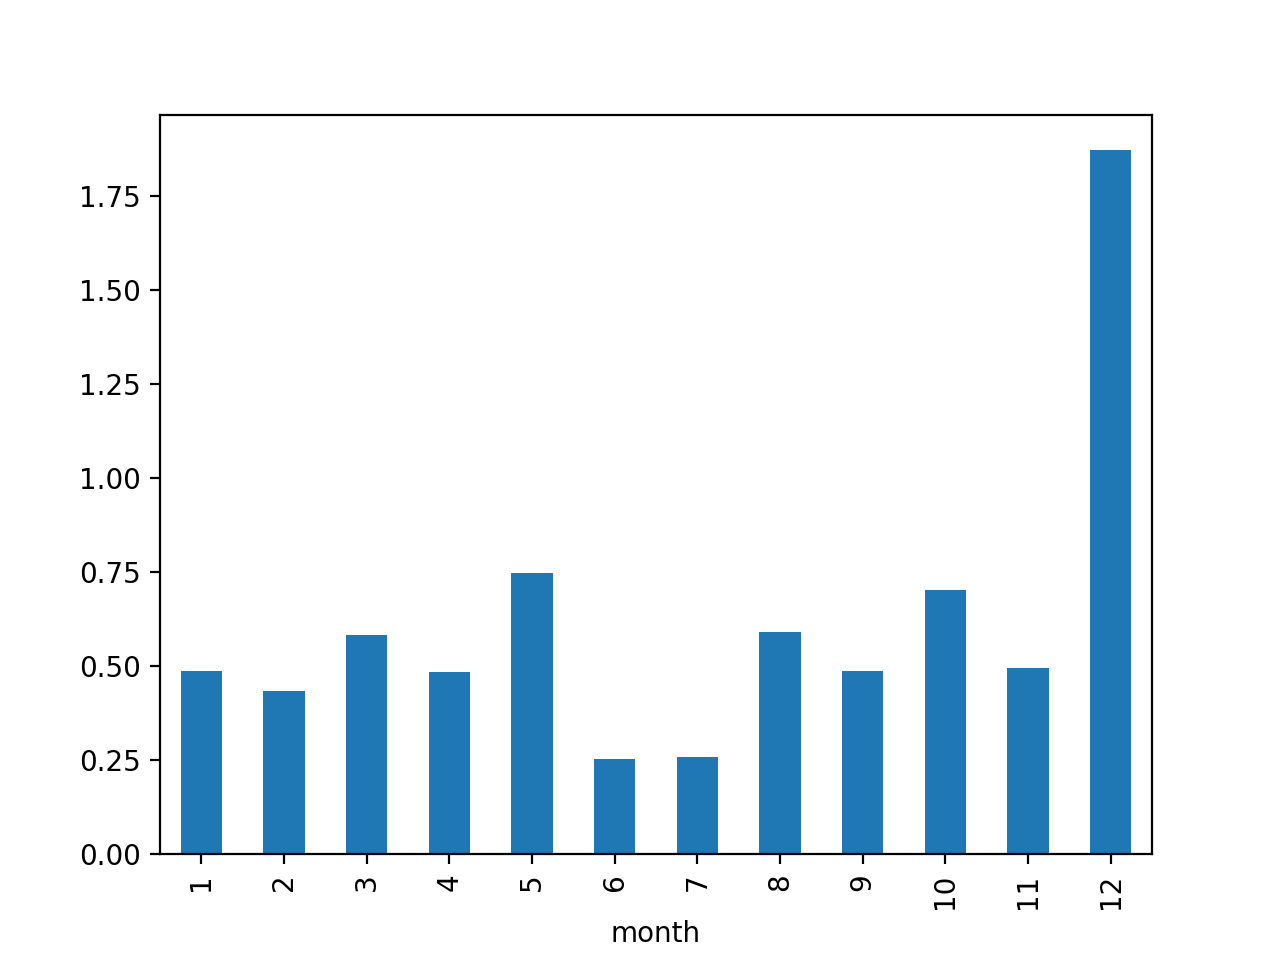

In [78]:
rmse_monthly.plot(
    kind = 'bar', x = 'month', y = 'RMSE_norm',
    legend = False
);

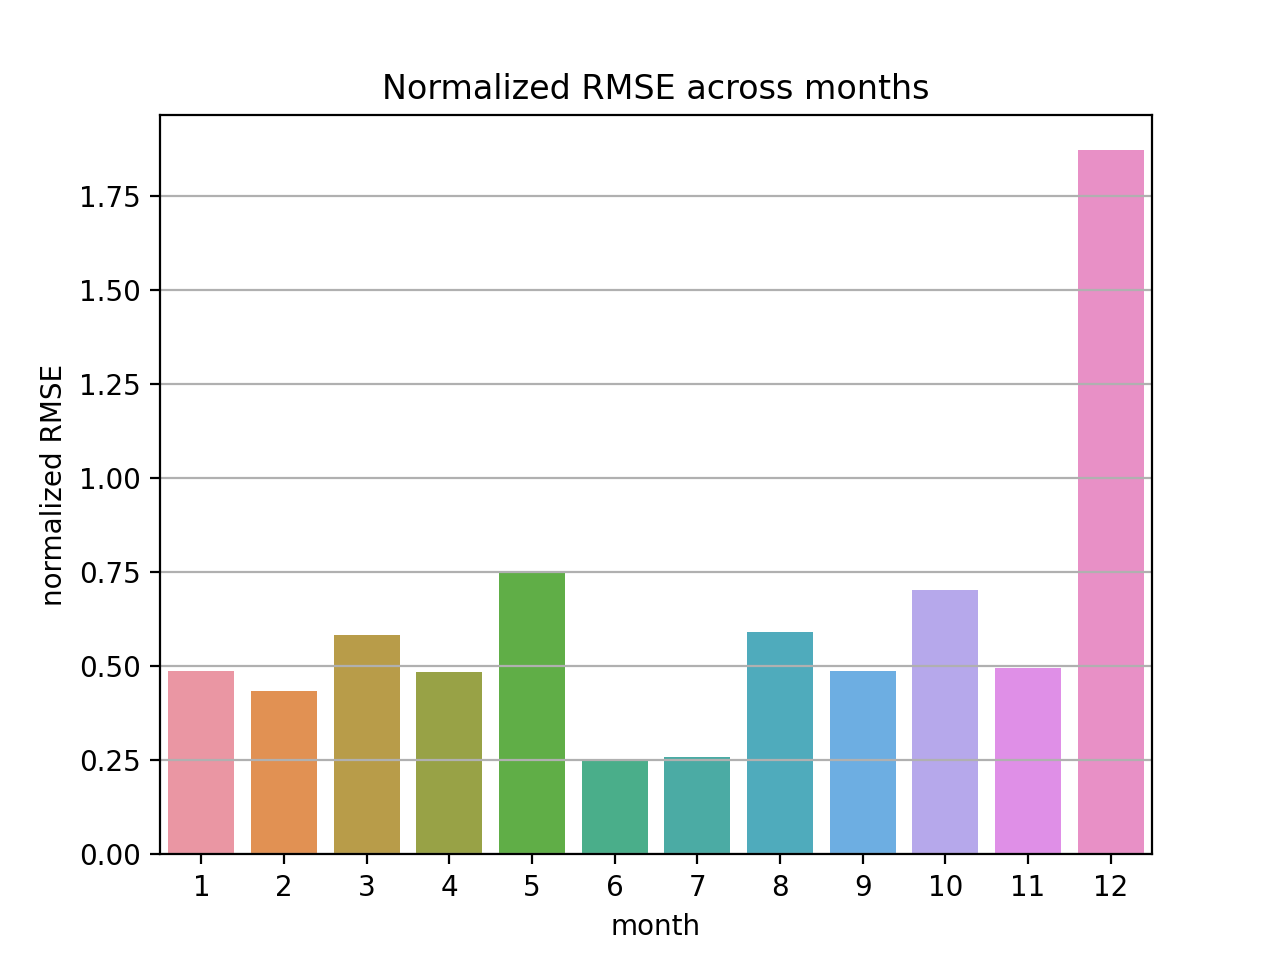

In [79]:
ax = sns.barplot(data = rmse_monthly, x = 'month', y = 'RMSE_norm')
ax.grid(visible = True, axis = 'y')
ax.set_ylabel('normalized RMSE')
ax.set_title('Normalized RMSE across months');

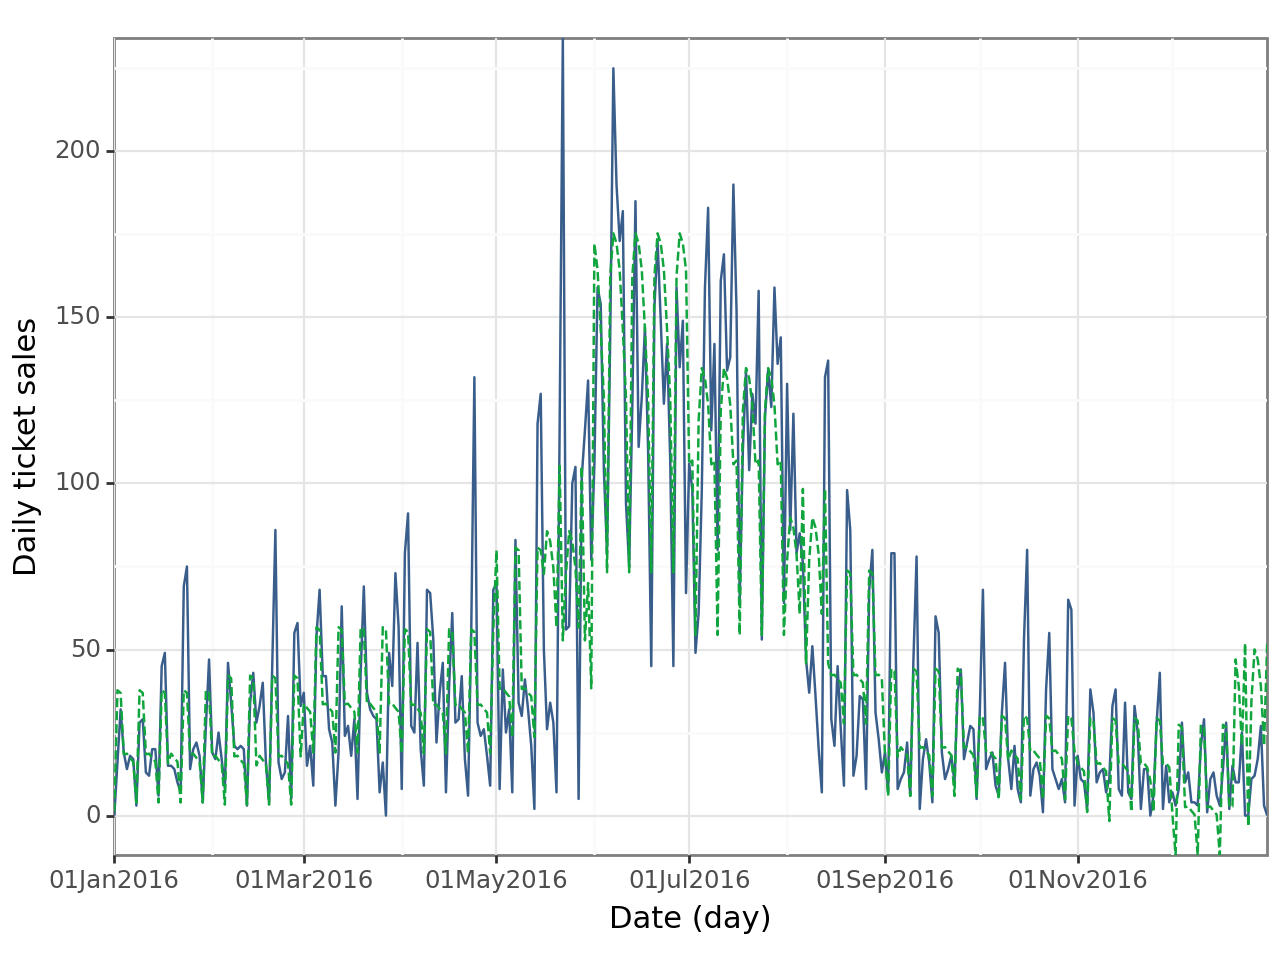

<Figure Size: (640 x 480)>

In [80]:
(
    ggplot(data_holdout, aes(x="date"))
    + geom_line(aes(y="QUANTITY"), color=color[0], linetype="solid")
    + geom_line(aes(y="y_hat_5"), color=color[1], linetype="dashed")
    + scale_y_continuous(expand=(0, 0))
    + scale_x_date(
        expand=(0, 0),
        breaks=[
            "2016-01-01",
            "2016-03-01",
            "2016-05-01",
            "2016-07-01",
            "2016-09-01",
            "2016-11-01",
            "2017-01-01",
        ],
        labels=date_format("%d%b%Y"),
        date_minor_breaks="1 month",
    )
    + scale_linetype_manual(name="", values=("solid", "twodash"))
    + labs(x="Date (day)", y="Daily ticket sales")
    + scale_fill_identity(name="", breaks=color[0:2], labels=["Actual", "Predicted"])
    + theme_bw()
)

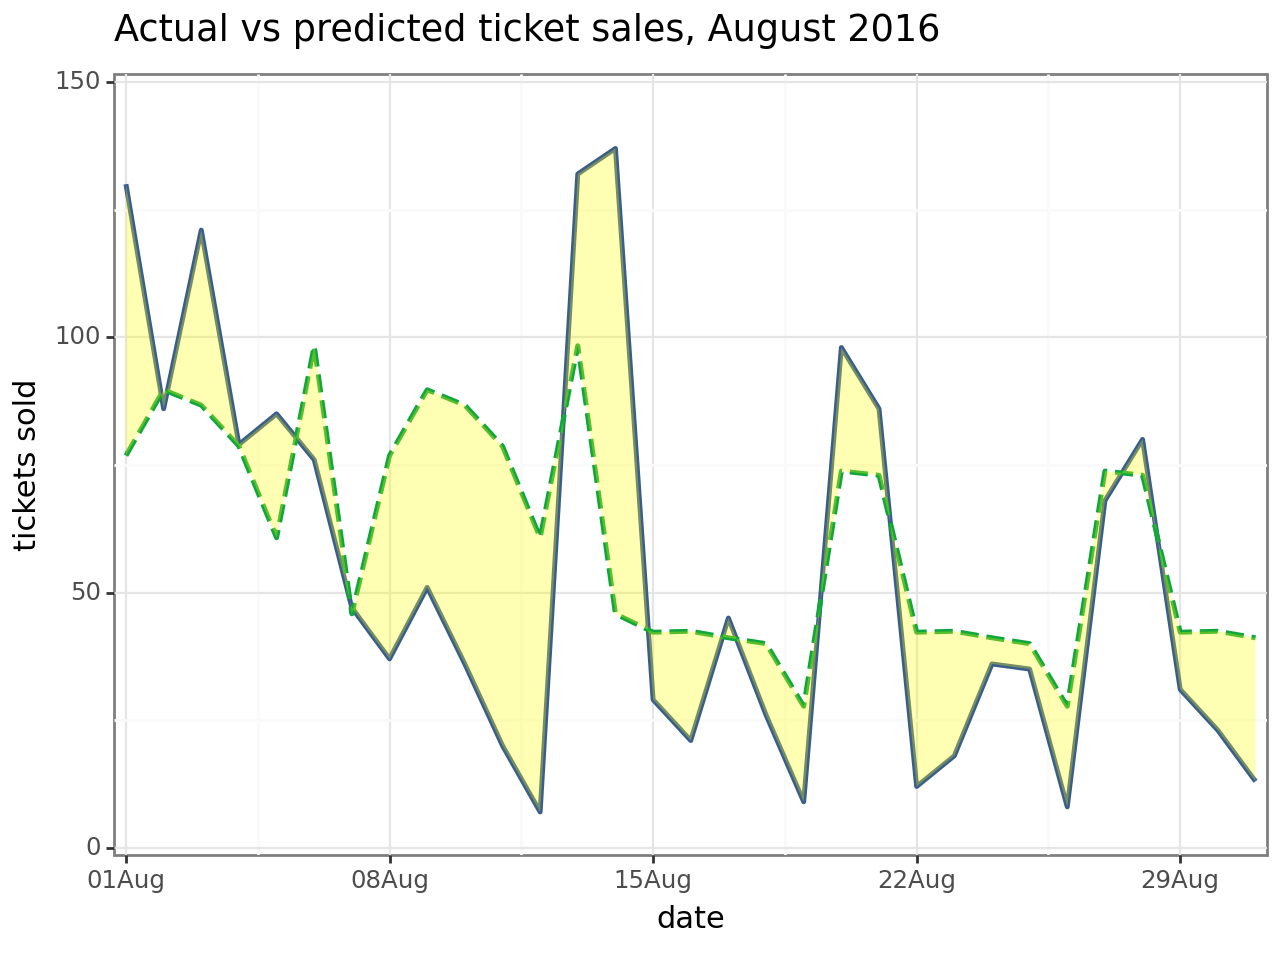

<Figure Size: (640 x 480)>

In [81]:
(
    ggplot(data_holdout.query("month == 8"), aes(x="date"))
    + geom_line(aes(y="QUANTITY"), color=color[0], size=1)
    + geom_line(aes(y="y_hat_5"), color=color[1], linetype="dashed", size=1)
    + geom_ribbon(aes(ymin="QUANTITY", ymax="y_hat_5"), fill="yellow", alpha=0.3)
    + labs(y = 'tickets sold', title = 'Actual vs predicted ticket sales, August 2016')
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 150))
    + scale_x_date(
        expand=(0.01, 0.01),
        breaks=["2016-08-01", "2016-08-08", "2016-08-15", "2016-08-22", "2016-08-29"],
        labels=date_format("%d%b"),
    )
    + theme_bw()
)

In [82]:
x = data_holdout[(data_holdout.year == 2016) & (data_holdout.month == 8)].date
y1 = data_holdout[(data_holdout.year == 2016) & (data_holdout.month == 8)].QUANTITY
y2 = data_holdout[(data_holdout.year == 2016) & (data_holdout.month == 8)].y_hat_5

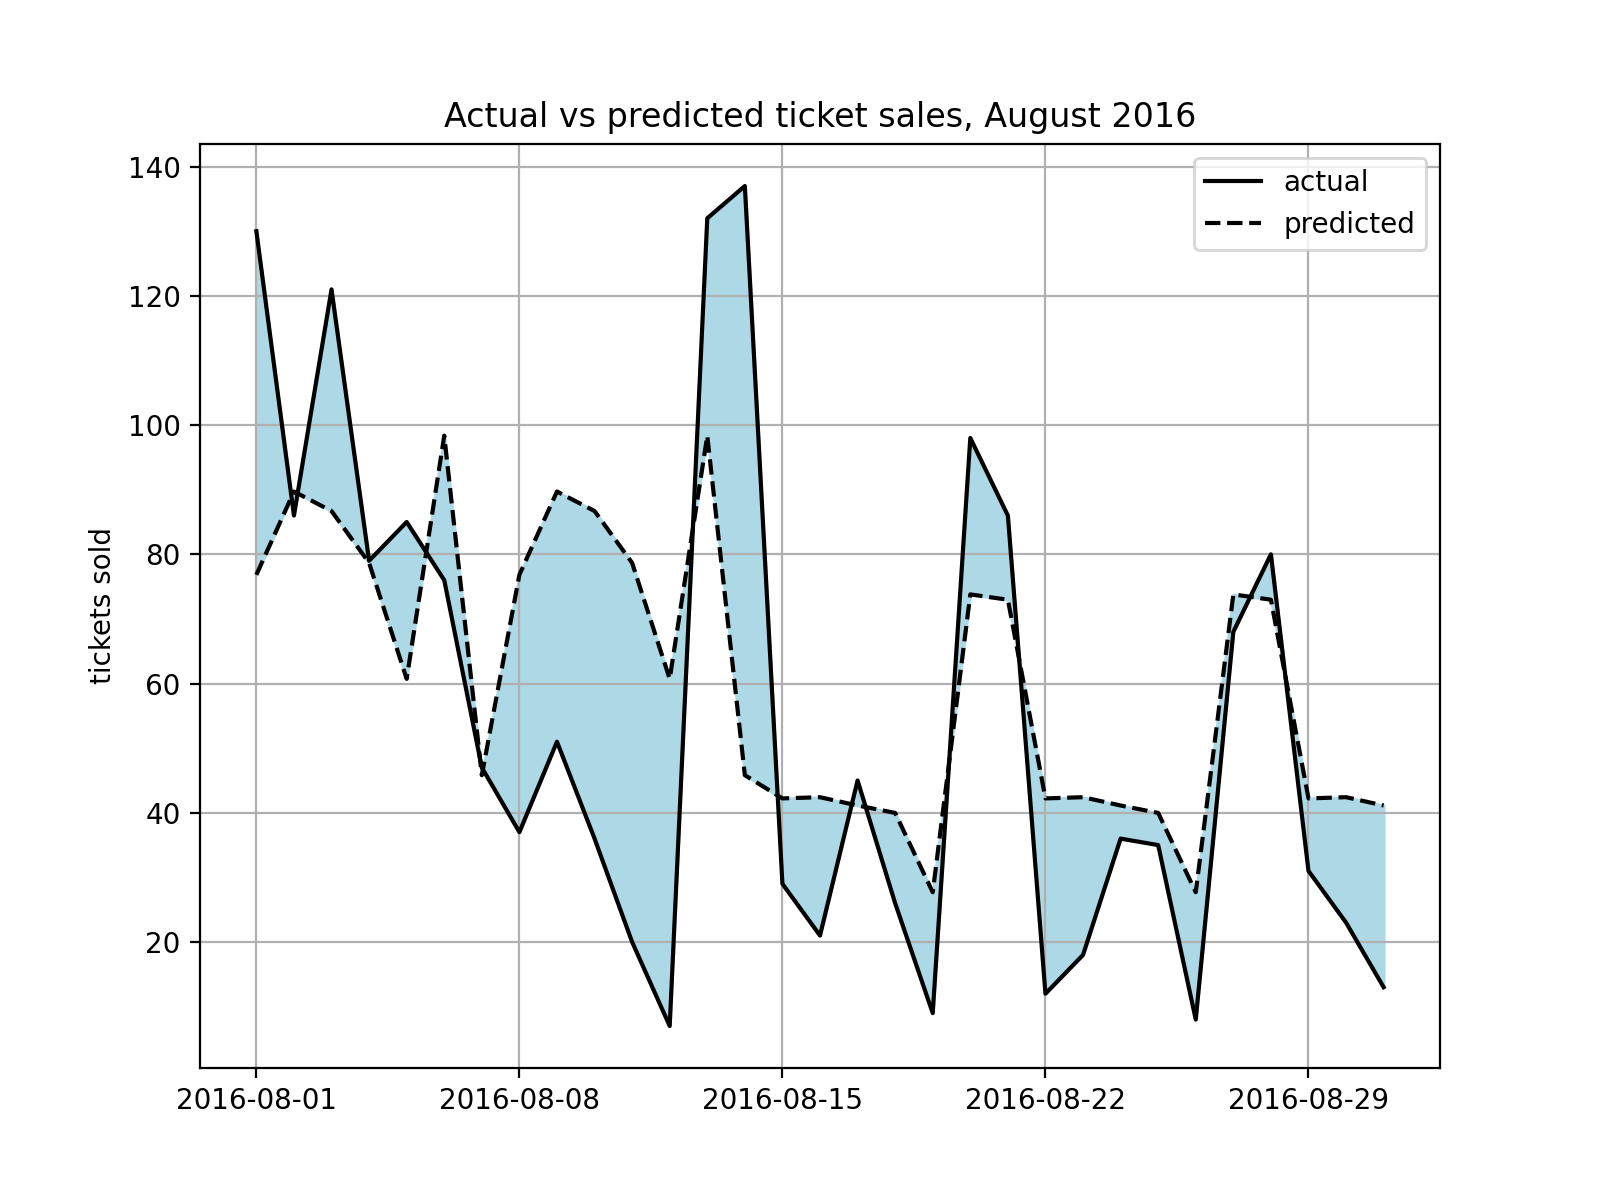

In [83]:
plt.subplots(figsize = (8,6))
plt.plot(x, y1, color = 'k')
plt.plot(x, y2, color = 'k', linestyle = '--')
plt.fill_between(x, y1, y2, color = 'lightblue')
plt.legend(['actual', 'predicted'])
plt.ylabel('tickets sold')
plt.grid(True)
plt.title('Actual vs predicted ticket sales, August 2016')
plt.xticks(x.tolist()[0::7]);